In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os



# Get the absolute path of the directory containing the module
module_dir = os.path.abspath('../../src')

# Add the directory to sys.path
sys.path.insert(0, module_dir)
#for path in sys.path:
#    print(path)

import PySaRLAC as sl
import random
import math
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as pyplot
random.seed(1234)

In [2]:
#For reference, this is the mapping between operator index and operator name
idx_op_map = ["PiPiGnd","PiPiExc","Sigma"]
op_idx_map = dict()
for i in range(len(op_idx_map)):
    op_idx_map[idx_op_map[i]] = i

In [20]:
f = h5py.File('../../../combined_data.hdf5','r')

f.keys()

<KeysViewHDF5 ['bdj_data', 'j_data']>

In [4]:
#These are the operator pairs in the data set
jdata = f['j_data']
con = jdata['contains']['entries']
for e in con.keys():
    op1 = con[e].attrs["first"][0]
    op2 = con[e].attrs["second"][0]
    print(op1,op2,idx_op_map[op1],idx_op_map[op2])

0 0 PiPiGnd PiPiGnd
0 1 PiPiGnd PiPiExc
0 2 PiPiGnd Sigma
1 1 PiPiExc PiPiExc
1 2 PiPiExc Sigma
2 2 Sigma Sigma


In [5]:
#Lets get the jackknife data now
#we'll store just the upper triangular part of the correlator matrix
Lt=64
block_size = 8
nsample_unblocked = 741
nblock = nsample_unblocked // block_size
jdata = f['j_data']
jdata_cors = [ [None for j in range(3)] for i in range(3)] #3 ops
for i in range(3):
    for j in range(i,3):
        jdata_cors[i][j] = sl.CorrelationFunction(Lt)
        cdata = jdata['correlators']['m']["elem_%d_%d" % (i,j)]['series']
        for t in range(Lt):
            jvals = cdata["elem_%d" % t]['second'].attrs['data']
            assert len(jvals) == nblock
            jdist = sl.JackknifeDistribution(nblock)
            for s in range(nblock):
                jdist[s] = jvals[s]                        
            print(i,j,t,jdist)
            jdata_cors[i][j].setValue(t, jdist)
            jdata_cors[i][j].setCoord(t, float(t))

0 0 0 1720533968568.517334 +- 5152527015.142453
0 0 1 1308082730816.283691 +- 3838743441.830425
0 0 2 817893517712.709229 +- 2863212729.101227
0 0 3 546447262835.104431 +- 2279669730.728789
0 0 4 371442428617.719116 +- 1977207304.061023
0 0 5 255425904124.481415 +- 1755689182.491866
0 0 6 176186513933.533051 +- 1675816329.593119
0 0 7 121975341117.497650 +- 1675622507.859246
0 0 8 84486142123.333389 +- 1765400455.676582
0 0 9 58249791177.174446 +- 1879393121.904631
0 0 10 39940393601.323479 +- 1958523855.933918
0 0 11 27648826491.399117 +- 1990866054.886972
0 0 12 18821224075.937077 +- 2002394932.749103
0 0 13 12563605837.880201 +- 1979220601.150931
0 0 14 8421808271.079186 +- 1890603345.313394
0 0 15 6006876270.216669 +- 1801576701.302305
0 0 16 4230730202.962997 +- 1728716806.666870
0 0 17 3130040947.329866 +- 1666463901.359768
0 0 18 2141599622.018576 +- 1550578630.086805
0 0 19 1759634993.427925 +- 1447183512.452421
0 0 20 1391825459.095830 +- 1405494121.983228
0 0 21 1310339203.70

In [6]:
jdata_cors_no_sigma = [[jdata_cors[0][0],jdata_cors[0][1]],[jdata_cors[0][1],jdata_cors[1][1]]]
jdata_cors_no_pipiEx = [[jdata_cors[0][0],jdata_cors[0][2]],[jdata_cors[0][2],jdata_cors[2][2]]]
jdata_cors_pipi_111 = [[jdata_cors[0][0]]]


alpha = 1
beta = 1
gamma = 1

coeffs = [alpha, beta, gamma]
#print(type(jdata_cors[1][0]))

#jdata_cors

for i in range(3):
    for j in range(i,3):
        #print(i,j)
        jdata_cors[i][j] = jdata_cors[i][j]*coeffs[i]*coeffs[j]

In [7]:
def gevp_output(input_data, E_n, t_max, Dt, rebasing = False, rebased_time_slice = 1, rebased_Dt = 2):
    #time_array = np.arange(0, t_max)
    data = sl.CorrelationFunction(t_max)
    if rebasing == False:
        gevp_obj = sl.GEVP_OG(input_data)
        for i in range(0,t_max-1):
            for j in range(i+1, t_max):
                if j-i == Dt:
                    data.setValue(j, gevp_obj.run(i,j)[E_n])
                    data.setCoord(j, float(j))
        return  data
    if rebasing == True:
        gevp_obj = sl.GEVP(input_data)
        for i in range(0,t_max-1):
            for j in range(i+1, t_max):
                if j-i == Dt:
                    data.setValue(j, gevp_obj.run(i,j, rebased_time_slice, rebased_time_slice + 
                                                  rebased_Dt)[E_n])
                    data.setCoord(j, float(j))
        return data

/home/clemo556/Documents/PySARLaC/src/PySaRLAC/GEVP.py:267: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_values[i] = eigvals[idx]
/home/clemo556/Documents/PySARLaC/src/PySaRLAC/GEVP.py:253: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_values[i] = eigvals[idx2]
/home/clemo556/Documents/PySARLaC/src/PySaRLAC/GEVP.py:293: RuntimeWarning: invalid value encountered in log
  eff_result[i][j] = -(log(np.real(eig_val_t1_t0[j][i])/np.real(eig_val_t_t0[j][i]))) #-log(A/B)
/home/clemo556/Documents/PySARLaC/src/PySaRLAC/GEVP.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_values[i] = eigvals[idx]
/home/clemo556/Documents/PySARLaC/src/PySaRLAC/GEVP.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_values[i] = eigvals[idx2]


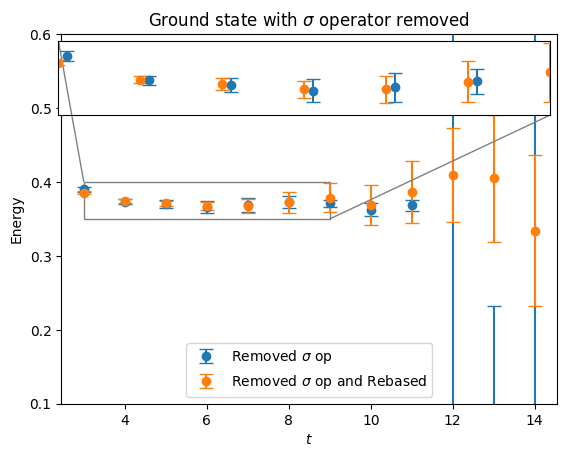

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, ax = plt.subplots()

gevp_without_sigma = gevp_output(jdata_cors_no_sigma, 0, 15, 3)

gevp_without_sigma_rebased = gevp_output(jdata_cors_no_sigma, 0, 15, 3, rebasing=True)


ax.errorbar(*gevp_without_sigma.plotInputs(), label = r"Removed $\sigma$ op", marker="o", capsize=5, linestyle='')
ax.errorbar(*gevp_without_sigma_rebased.plotInputs(), label = r"Removed $\sigma$ op and Rebased", marker="o", capsize=5, linestyle='')

x1, x2, y1, y2 = 3, 9, 0.35, 0.4
axins = zoomed_inset_axes(ax, zoom=2, loc='upper right')
axins.errorbar(gevp_without_sigma.plotInputs()[0]+0.1, *gevp_without_sigma.plotInputs()[1:], marker="o", capsize=5, linestyle='')
axins.errorbar(*gevp_without_sigma_rebased.plotInputs(), marker="o", capsize=5, linestyle='')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Hide ticks inside inset
axins.set_xticks([])
axins.set_yticks([])

# Draw lines between inset and zoomed area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.set_title(r"Ground state with $\sigma$ operator removed")
ax.set_ylabel("Energy")
ax.set_xlabel(r"$t$")
ax.set_ylim(0.1, 0.6)
ax.legend(loc = "lower center")

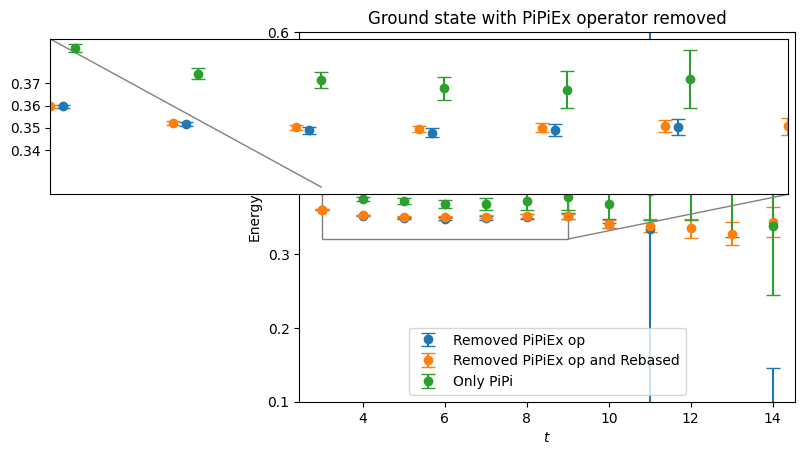

In [9]:
gevp_without_pipiEx = gevp_output(jdata_cors_no_pipiEx, 0, 15, 3)

gevp_without_pipiEx_rebased = gevp_output(jdata_cors_no_pipiEx, 0, 15, 3, rebasing=True)

gevp_without_pipi_111 = gevp_output(jdata_cors_pipi_111, 0, 15, 3)

fig, ax = plt.subplots()


ax.errorbar(*gevp_without_pipiEx.plotInputs(), label = r"Removed PiPiEx op", marker="o", capsize=5, linestyle='')
ax.errorbar(*gevp_without_pipiEx_rebased.plotInputs(), label = r"Removed PiPiEx op and Rebased", marker="o", capsize=5, linestyle='')
ax.errorbar(*gevp_without_pipi_111.plotInputs(), label = r"Only PiPi", marker="o", capsize=5, linestyle='')

x1, x2, y1, y2 = 3, 9, 0.32, 0.39
axins = zoomed_inset_axes(ax, zoom=3, loc='upper right')
axins.errorbar(gevp_without_pipiEx.plotInputs()[0]+0.1, *gevp_without_pipiEx.plotInputs()[1:], marker="o", capsize=5, linestyle='')
axins.errorbar(*gevp_without_pipiEx_rebased.plotInputs(), marker="o", capsize=5, linestyle='')
axins.errorbar(gevp_without_pipi_111.plotInputs()[0]+0.2, *gevp_without_pipi_111.plotInputs()[1:], label = r"Only PiPi", marker="o", capsize=5, linestyle='')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_yticks()
# Hide ticks inside inset
axins.set_xticks([])
axins.set_yticks([0.34,0.35, 0.36, 0.37])

# Draw lines between inset and zoomed area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.set_title(r"Ground state with PiPiEx operator removed")
ax.set_ylabel("Energy")
ax.set_xlabel(r"$t$")
ax.set_ylim(0.1, 0.6)
ax.legend(loc = "lower center")

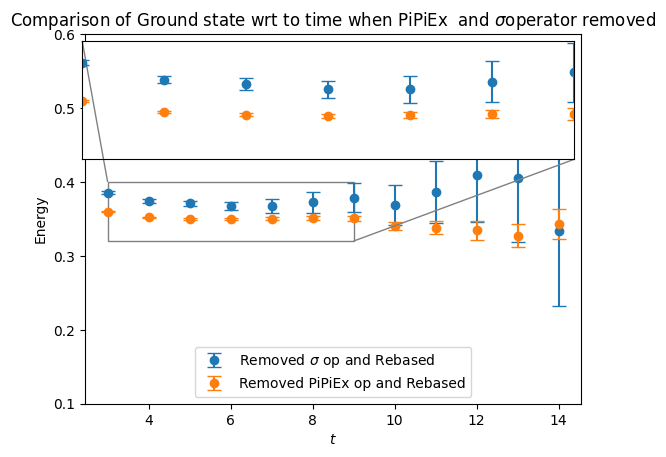

In [10]:
fig, ax = plt.subplots()


ax.errorbar(*gevp_without_sigma_rebased.plotInputs(), label = r"Removed $\sigma$ op and Rebased", marker="o", capsize=5, linestyle='')
ax.errorbar(*gevp_without_pipiEx_rebased.plotInputs(), label = r"Removed PiPiEx op and Rebased", marker="o", capsize=5, linestyle='')

x1, x2, y1, y2 = 3, 9, 0.32, 0.4
axins = zoomed_inset_axes(ax, zoom=2, loc='upper right')
axins.errorbar(*gevp_without_sigma_rebased.plotInputs(), marker="o", capsize=5, linestyle='')
axins.errorbar(*gevp_without_pipiEx_rebased.plotInputs(), marker="o", capsize=5, linestyle='')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Hide ticks inside inset
axins.set_xticks([])
axins.set_yticks([])

# Draw lines between inset and zoomed area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.set_title(r"Comparison of Ground state wrt to time when PiPiEx  and $\sigma $operator removed")
ax.set_ylabel("Energy")
ax.set_xlabel(r"$t$")
ax.set_ylim(0.1, 0.6)
ax.legend(loc = "lower center")

/home/clemo556/Documents/PySARLaC/src/PySaRLAC/GEVP.py:254: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_vectors[i] = eigvecs[:,idx2]


Rebasing


/home/clemo556/Documents/PySARLaC/src/PySaRLAC/GEVP.py:143: RuntimeWarning: invalid value encountered in log
  eff_result[i][j] = -(log(np.real(eig_val_t1_t0[j][i])/np.real(eig_val_t_t0[j][i]))) #-log(A/B)


(-0.3, 0.4)

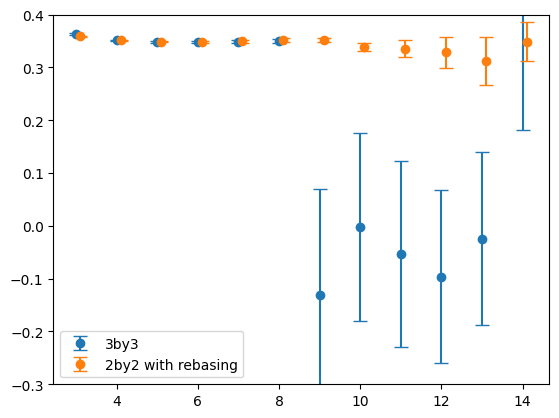

In [11]:
gevp_3by3 = gevp_output(jdata_cors, 0, 15, 3)
print("Rebasing")
gevp_3by3_rebased = gevp_output(jdata_cors, 0, 15, 3, rebasing=True)


fig, ax = plt.subplots()


ax.errorbar(*gevp_3by3.plotInputs(), label = r"3by3", marker="o", capsize=5, linestyle='')
ax.errorbar(gevp_3by3_rebased.plotInputs()[0]+0.1, *gevp_3by3_rebased.plotInputs()[1:], label = r"2by2 with rebasing", marker="o", capsize=5, linestyle='')
ax.legend()
ax.set_ylim(-0.3, 0.4)



Rebasing


(0.0, 1.0)

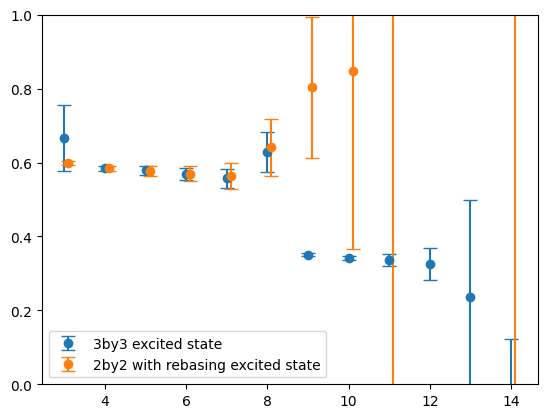

In [12]:
gevp_3by3_Ex = gevp_output(jdata_cors, 1, 15, 3)
print("Rebasing")
gevp_3by3_rebased_Ex = gevp_output(jdata_cors, 1, 15, 3, rebasing=True)


fig, ax = plt.subplots()


ax.errorbar(*gevp_3by3_Ex.plotInputs(), label = r"3by3 excited state", marker="o", capsize=5, linestyle='')
ax.errorbar(gevp_3by3_rebased_Ex.plotInputs()[0]+0.1, *gevp_3by3_rebased_Ex.plotInputs()[1:], label = r"2by2 with rebasing excited state", marker="o", capsize=5, linestyle='')
ax.legend()
ax.set_ylim(0, 1)


#if gevp fails then discard entire time-slice
#perform fits (Change rabased params st the orange curve error bar are similar to blue error bars)
#Write results up with all data thus far with various fits (similar to small research paper) ---> draw conclusions (prepare for monday meeting)
#Compare with 2020 results, use same t_min as paper (t_min=6), do 3by3 and 2by2 with rebasing

<h3>Running tests for variable rebased Dt and t0</h3>

(0.51, 0.68)

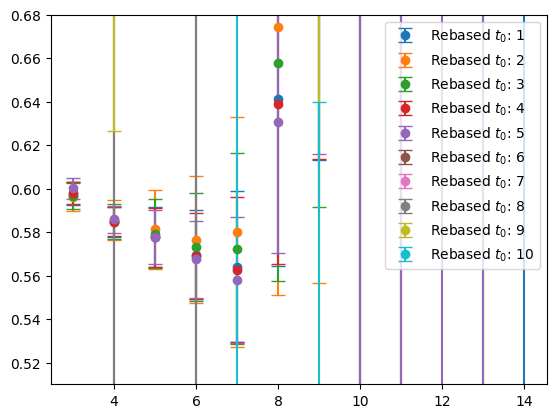

In [13]:
N_rebased_slices = 10

rebased_GEVP_for_variable_timeslice =  np.empty(N_rebased_slices, dtype=sl.CorrelationFunction)

rebased_t0 = 1

for i in range(N_rebased_slices):
    
    rebased_GEVP_for_variable_timeslice[i] = gevp_output(jdata_cors, 1, 15, 3, rebased_time_slice = i + rebased_t0, rebasing = True)
    
fig, ax = plt.subplots()

for j in range(N_rebased_slices):
    ax.errorbar(*rebased_GEVP_for_variable_timeslice[j].plotInputs(), label = rf"Rebased $t_0$: {j + rebased_t0}", marker="o", capsize=5, linestyle='')
    
ax.legend()
ax.set_ylim(0.51, 0.68)

(0.51, 0.68)

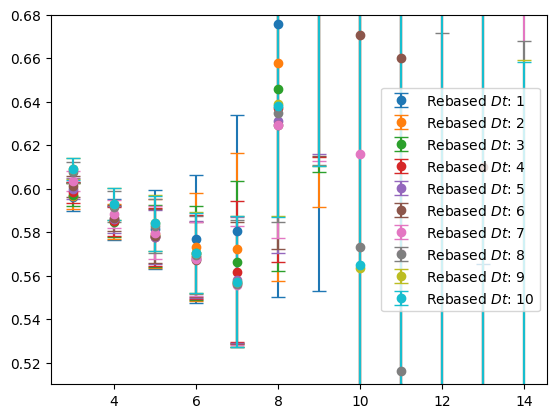

In [14]:
N_rebased_Dt = 10

rebased_GEVP_for_variable_Dt=  np.empty(N_rebased_slices, dtype=sl.CorrelationFunction)

rebased_Dt0 = 1

for i in range(N_rebased_slices):
    
    rebased_GEVP_for_variable_Dt[i] = gevp_output(jdata_cors, 1, 15, 3, rebased_Dt = i + rebased_Dt0, rebased_time_slice = 3, rebasing = True)
    
fig, ax = plt.subplots()

for j in range(N_rebased_Dt):
    ax.errorbar(*rebased_GEVP_for_variable_Dt[j].plotInputs(), label = rf"Rebased $Dt$: {j + rebased_Dt0}", marker="o", capsize=5, linestyle='')
    
ax.legend()
ax.set_ylim(0.51, 0.68)

(0.51, 0.68)

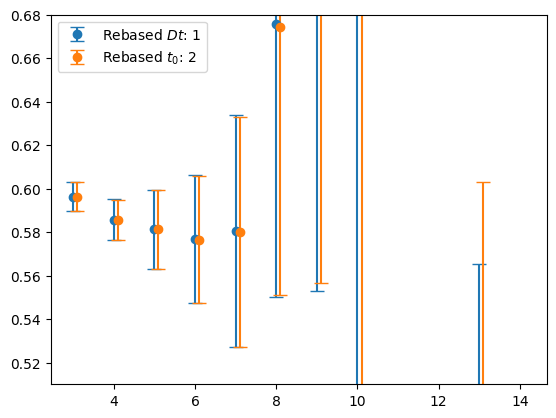

In [17]:
fig, ax = plt.subplots()
ax.errorbar(*rebased_GEVP_for_variable_Dt[0].plotInputs(), label = rf"Rebased $Dt$: {0 + rebased_Dt0}", marker="o", capsize=5, linestyle='')
ax.errorbar(*rebased_GEVP_for_variable_timeslice[1].plotInputs(x_offset = 0.1), label = rf"Rebased $t_0$: {1 + rebased_t0}", marker="o", capsize=5, linestyle='')
ax.legend()
ax.set_ylim(0.51, 0.68)


<h1>Fitting</h1>

In [16]:

jack_correlation = sl.CorrelationFunction(Lt)
dd_jack = sl.CorrelationFunction(Lt)
for t0 in range(0,Lt):
    t = t0 + Dt
    jack_correlation.setCoord(t0, float(t))
    #print(j_dists[t])
    jack_correlation.setValue(t0, j_dists[t0])
    dd_jack.setCoord(t0, float(t0))
    dd_jack.setValue(t0, j_dists2[t0])


NameError: name 'Dt' is not defined